In [44]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time
import random
import pickle
import scipy

import mlrfit as mf
import hfmfit as hf

from scipy.sparse import coo_matrix
from scipy.linalg import block_diag

In [2]:
np.random.seed(1001)
random.seed(1001)

# True model is MLR factor model with SNR = 4 

Let $\Sigma = FF^T + D$ be MLR. We generate samples using 
$$
y = Fz + e, \qquad z \sim N(0, I), \qquad N(0, D).
$$

In [3]:
mtype = "small_mlr_hier"
n = 300
signal_to_noise = 4


nsamples = 20
L = 4

ranks = np.array([4, 3, 2, 1])
rank = ranks.sum()

In [4]:
pi_rows = np.random.permutation(n)
hpart = {'rows':{'pi':pi_rows, 'lk':[]}, 'cols':{'pi':pi_rows, 'lk':[]}} 
for ngroups in [2, 5, 9, n+1]:
       hpart['rows']['lk'] += [ np.linspace(0, n, ngroups, endpoint=True, dtype=int)]
hpart['cols']['lk'] = hpart['rows']['lk']
part_sizes = hf.print_hpart_numgroups(hpart)

level=0, num_groups=1, mean_size=300.0
level=1, num_groups=4, mean_size=75.0
level=2, num_groups=8, mean_size=37.5
level=3, num_groups=300, mean_size=1.0


In [5]:
true_mlr, true_sparse_F, true_D_noise = hf.generate_mlr_model(n, hpart, ranks, signal_to_noise)

signal_var=8.837876183246516, noise_var=2.2576120524425716
SNR=3.9147010106030304, signal_to_noise=4


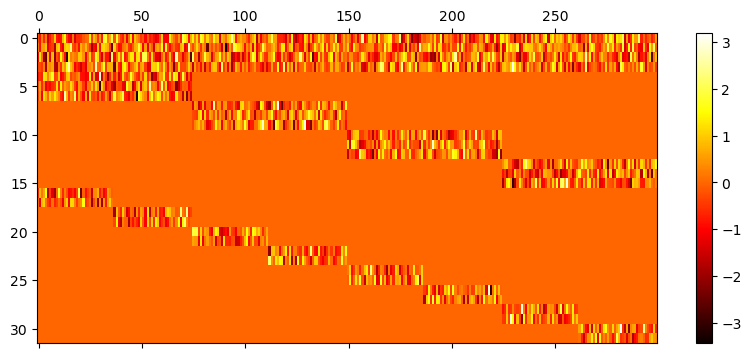

(300, 32)


In [6]:
plt.figure(figsize=(10, 4)) 
plt.matshow(true_sparse_F.T, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()
print(true_sparse_F.shape)

In [7]:
type(true_sparse_F)

numpy.ndarray

In [8]:
filename = "%s_r%d_%d"%(mtype, rank, n)

In [9]:
row_selectors, si_groups, F_hpart, groups_all = hf.row_col_selections(hpart, return_groups=True)

num_levels=4, num_sparsities=8
(8, 3) [0 3 7]


In [34]:
def convert_compressed_to_sparse(B:np.ndarray, hp_entry:mf.EntryHpartDict, ranks:np.ndarray, mtype='csc'):
    # tilde_F0 = convert_compressed_to_sparse(F0, F_hpart, ranks[:-1])
    data, i_idx, j_idx = [], [], []
    col_count = 0
    num_levels = len(hp_entry['lk'])
    for level in range(num_levels):
        # B_level = B[:,ranks[:level].sum():ranks[:level+1].sum()]
        num_blocks = len(hp_entry['lk'][level])-1
        for block in range(num_blocks):
            r1, r2 = hp_entry['lk'][level][block], hp_entry['lk'][level][block+1]
            data += [B[:,ranks[:level].sum():ranks[:level+1].sum()][r1:r2].flatten(order='C')]
            i_idx += [np.tile(np.arange(r1, r2), [ranks[level],1]).flatten(order='F')]
            j_idx += [np.tile(np.arange(col_count, col_count+ranks[level]), [r2-r1])]
            col_count += ranks[level]
    data = np.concatenate(data, axis=0)
    i_idx = np.concatenate(i_idx, axis=0)
    j_idx = np.concatenate(j_idx, axis=0)

    s = sum([(len(hp_entry['lk'][level])-1)*ranks[level] for level in range(num_levels)])
    tilde_B = coo_matrix((data, (i_idx, j_idx)), shape=(B.shape[0], s))
    if mtype == 'csc':
        tilde_B = tilde_B.tocsc()
    elif mtype == 'csr':
        tilde_B = tilde_B.tocsr()
    return tilde_B


In [ ]:
def mult_blockdiag_refined2(A, lk_A, B, lk_B):
    # multiply blockdiagonal matrix by blockdiagonal matrix
    # with A having column sparity that is a refinement of B row sparsity
    # A, B given in compressed format
    assert lk_A.size >= lk_B.size and lk_B[-1] == B.shape[0] and lk_A[-1] in A.shape
    num_blocks_B = lk_B.size - 1
    indices_A2B = np.searchsorted(lk_A, lk_B, side='right')
    res = []
    # decide whether make A block diagonal by splitting rows or columns
    if lk_A[-1] == A.shape[0]:
        for block_B in range(num_blocks_B):
            for a in range(lk_A[indices_A2B[block_B]-1 : indices_A2B[block_B + 1]].size-1):
                A_lk = A[lk_A[indices_A2B[block_B]-1 + a] : lk_A[indices_A2B[block_B] + a]]
                B_lk = B[lk_A[indices_A2B[block_B]-1 + a] : lk_A[indices_A2B[block_B] + a]]
                res += [A_lk @ B_lk]
                del A_lk, B_lk
    if lk_A[-1] == A.shape[0]:
        return np.concatenate(res, axis=0)
    else:
        return np.concatenate(res, axis=1)

In [104]:
def block_diag_AB(lk:np.array, A:np.ndarray, B:np.ndarray):
    # return blockdiagonal(A) @ blockdiagonal(B)
    res = []
    num_blocks = lk.size - 1
    for block in range(num_blocks):
        r1, r2 = lk[block], lk[block+1]
        res += [ A[r1:r2] @ B[:, r1:r2] ]
    return block_diag(*res)


def block_diag_lk(lk:np.array, A:np.ndarray):
    # return blockdiagonal(A)
    res = []
    num_blocks = lk.size - 1
    for block in range(num_blocks):
        r1, r2 = lk[block], lk[block+1]
        res += [ A[r1:r2]]
    return block_diag(*res)


def mult_blockdiag_refined_AtB(A, lk_A, B, lk_B):
    # multiply blockdiagonal matrix by blockdiagonal matrix
    # with At having column sparity that is a refinement of B row sparsity
    # A, B given in compressed format
    assert lk_A.size >= lk_B.size and lk_B[-1] == B.shape[0] and lk_A[-1] in A.shape
    num_blocks_A = lk_A.size - 1
    res = np.zeros((A.shape[1] * (lk_A.size - 1), B.shape[1]))
    # decide whether make A block diagonal by splitting rows or columns
    for block_A in range(num_blocks_A):
        r1, r2 = lk_A[block_A], lk_A[block_A+1]
        res[block_A * A.shape[1] : (block_A+1) * A.shape[1]] = A[r1:r2].T @ B[r1:r2]
    return res

In [105]:
lk_A = F_hpart['lk'][2]
lk_B = F_hpart['lk'][1]
lk_A, lk_B

(array([  0,  37,  75, 112, 150, 187, 225, 262, 300]),
 array([  0,  75, 150, 225, 300]))

In [106]:
A = true_sparse_F[:,ranks[:2].sum():ranks[:2+1].sum()]
B = true_sparse_F[:,ranks[:1].sum():ranks[:1+1].sum()]

In [109]:
AtB = block_diag_lk(lk_A, A).T @  block_diag_lk(lk_B, B)
res = mult_blockdiag_refined_AtB(A, lk_A, B, lk_B)
assert np.allclose(AtB, block_diag_lk(lk_B, res))

In [52]:
AAt = hf.block_diag_FFt(2, F_hpart, A)
assert np.allclose(AAt, block_diag_AB(lk_A, A, A.T)) and np.allclose(AAt, block_diag_lk(lk_A, A) @  block_diag_lk(lk_A, A).T)

In [30]:
# indices of groups in A that refine groups in B
indices_A2B = np.searchsorted(lk_A, lk_B, side='right')
indices_A2B

array([1, 3, 5, 7, 9])

In [32]:
for b in range(indices_A2B.size-1):
    print(lk_A[indices_A2B[b]-1 : indices_A2B[b+1]][:-1])

[ 0 37]
[ 75 112]
[150 187]
[225 262]
